<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Import-Necessary-Libraries" data-toc-modified-id="Import-Necessary-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Necessary Libraries</a></span></li><li><span><a href="#Anonymous-Functions" data-toc-modified-id="Anonymous-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Anonymous Functions</a></span></li><li><span><a href="#Named-Functions" data-toc-modified-id="Named-Functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Named Functions</a></span></li></ul></li><li><span><a href="#Load-and-Clean-Data" data-toc-modified-id="Load-and-Clean-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and Clean Data</a></span><ul class="toc-item"><li><span><a href="#Separate-Data" data-toc-modified-id="Separate-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Separate Data</a></span></li></ul></li><li><span><a href="#Determine-Appropriate-$m$-Values" data-toc-modified-id="Determine-Appropriate-$m$-Values-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Determine Appropriate $m$ Values</a></span><ul class="toc-item"><li><span><a href="#Monomer" data-toc-modified-id="Monomer-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Monomer</a></span></li><li><span><a href="#Dimer" data-toc-modified-id="Dimer-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Dimer</a></span></li><li><span><a href="#Trimer" data-toc-modified-id="Trimer-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Trimer</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Get-Averages-and-Compare-to-Literature-Values" data-toc-modified-id="Get-Averages-and-Compare-to-Literature-Values-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Get Averages and Compare to Literature Values</a></span><ul class="toc-item"><li><span><a href="#Final-Results" data-toc-modified-id="Final-Results-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Final Results</a></span></li></ul></li></ul></div>

# Preamble
## Import Necessary Libraries

In [1]:
import pickle as pkl
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
sns.set()
sns.set_context("talk")



## Anonymous Functions

These are used to make certain repeated tasks easier

In [2]:
filter_system = lambda system,kpt,df: df[(df.system==system) & (df.kpts==kpt)]
pull_dipoles = lambda df: [i[0] for i in df.dipoles.values.tolist()]
drop_outliers = lambda df,m: df.drop(df.index[return_outliers(df.total_dipole,m=m)])
get_total_dipole = (lambda df,m: (drop_outliers(df,m=m).total_dipole.mean(),
                                      drop_outliers(df,m=m).total_dipole.std()/
                                      np.sqrt(len(drop_outliers(df,m=m).total_dipole))))
get_avg_dipole = (lambda df,m: (np.mean(pull_dipoles(drop_outliers(df,m=m))),
                                    np.std(pull_dipoles(drop_outliers(df,m=m)))/
                                    np.sqrt(len(pull_dipoles(drop_outliers(df,m=m))))))

## Named Functions

These are used for larger tasks.

In [34]:
def reject_outliers(data, m = 1.):
        '''Used modified Z-score itl.nist.gov/div898/handbook/eda/section3/eda35h.htm '''
        data = np.array(data)
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
def return_outliers(data, m = 1.0):
    '''Used modified Z-score itl.nist.gov/div898/handbook/eda/section3/eda35h.htm '''
    data = np.array(data)
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    reject = list(data[s>=m])
    return [list(data).index(i) for i in reject]

def do_m_scan(df):
    fig = plt.figure(figsize=(10,10));
    gs = GridSpec(3,3,figure=fig);
    fig.subplots_adjust(hspace=0.5)
    fig.text(0.5, 0.04, 'Dipole [Debye]', ha='center',fontsize=16)
    fig.text(0.04, 0.5, 'Kernel Density Estimate [a.u.]', va='center', rotation='vertical',fontsize=16)
    system = df.system.unique()[0]
    nkpts = df.kpts.unique()[0]
    #fig.suptitle("M-Scan for {} (Kpts {})".format(system.upper(),nkpts),fontsize=20)
    for i in range(9):
        if i < 3:
            row = 0
        elif i<6:
            row = 1 
        else:
            row = 2
        col = i%3
        m=(i+1)/1
        sns.kdeplot(drop_outliers(df,m=m).total_dipole,ax=fig.add_subplot(gs[row,col]),bw=0.05)
        a = plt.gca()
        a.set(title="m={}".format(m))
        a.get_legend().remove()
        
        
def plot_before_after(df,m=1.0):
    before = df
    after = drop_outliers(df,m=m)
    
    system = before.system.unique()[0]
    nkpts = before.kpts.unique()[0]
    fig = plt.figure(figsize=(12,12));
    fig.subplots_adjust(hspace=0.5)
    fig.text(0.5, 0.04, 'Dipole [Debye]', ha='center',fontsize=20)
    fig.text(0.04, 0.5, 'Kernel Density Estimate [a.u.]', va='center', rotation='vertical',fontsize=20)
    #plt.gcf().suptitle("System: {}\nkpts: {}\nm={}".format(system.upper(),nkpts,m),fontsize=22)
    plt.subplot(221)
    plt.gca().set_title("Full, Total Dipole")
    sns.distplot(before.total_dipole,norm_hist=True,label="Full");
    plt.gca().set(xlabel=None)
    plt.subplot(223)
    plt.gca().set_title("Cleaned, Total Dipole")
    sns.distplot(after.total_dipole,norm_hist=True);
    plt.gca().set(xlabel=None)
    plt.subplot(222)
    plt.gca().set_title("Full, Dipoles")
    sns.distplot(pull_dipoles(before),norm_hist=True);
    plt.subplot(224)
    plt.gca().set_title("Cleaned, Dipoles")
    sns.distplot(pull_dipoles(after),norm_hist=True);
    

def make_final_graph(m=1.):
    lit_values = {'nmer': [1,2,3],
                  'total_dipole' : [1.868,2.683,1.071],
                  'avg_dipole': [1.868,2.100,2.32]}

    final_results = {'nmer':[1,2,3],
                        'total_dipole':[get_total_dipole(monomer_4_df,m=m)[0],
                                        get_total_dipole(dimer_4_df,m=m)[0],
                                        get_total_dipole(trimer_4_df,m=m)[0]],
                         'total_dipole_error':[get_total_dipole(monomer_4_df,m=m)[1],
                                               get_total_dipole(dimer_4_df,m=m)[1],
                                               get_total_dipole(trimer_4_df,m=m)[1]],
                         'avg_dipole':[get_avg_dipole(monomer_4_df,m=m)[0],
                                       get_avg_dipole(dimer_4_df,m=m)[0],
                                       get_avg_dipole(trimer_4_df,m=m)[0]],
                         'avg_dipole_error':[get_avg_dipole(monomer_4_df,m=m)[1],
                                             get_avg_dipole(dimer_4_df,m=m)[1],
                                             get_avg_dipole(trimer_4_df,m=m)[1]]}

    final_results_df = pd.DataFrame(final_results)
    lit_values_df = pd.DataFrame(lit_values)

    fig = plt.figure(figsize=(12,12));
    fig.subplots_adjust(hspace=0.5)
    gs = GridSpec(2,1,figure=fig);
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])


    ax1.errorbar(final_results_df.nmer,final_results_df.avg_dipole,
                 yerr=final_results_df.avg_dipole_error,label="Average Dipole")
    ax1.plot(lit_values_df.nmer,lit_values_df.avg_dipole,label="Literature")
    ax1.set_xlabel("n-mer",fontsize=16)
    ax1.set_ylabel("Average Dipole [Debye]",fontsize=16)
    ax1.legend()

    ax2.errorbar(final_results_df.nmer,final_results_df.total_dipole,
                 yerr=final_results_df.total_dipole_error,label="Total Dipole")
    ax2.plot(lit_values_df.nmer,lit_values_df.total_dipole,label="Literature")
    ax2.set_xlabel("n-mer",fontsize=16)
    ax2.set_ylabel("Total Dipole [Debye]",fontsize=16)
    ax2.legend();
    
    return final_results_df, lit_values_df

# Load and Clean Data

Here, the raw data is unpickled in `raw_data`, and it is melted into dataframe `df` according to tidy data principles.

In [4]:
raw_data = pkl.load(open("tidy_data/pc_water_benchmark_round2.pkl","rb"))
kpts = []
runs = []
systems = []
total_dipoles = []
dipoles = []

for entry in raw_data:
    kpt = entry["sys_info"]["kpts"]
    run = entry["sys_info"]["run"]
    system = entry["sys_info"]["sys"]
    total_dipole = entry["total_dipole"]
    
    kpts.append(kpt)
    runs.append(run)
    systems.append(system)
    total_dipoles.append(total_dipole)

# For some reason, this needs to be done like this
dipoles = [i['dipoles'] for i in raw_data]

df = pd.DataFrame()
df['system'] = systems
df['kpts'] = kpts
df['runs'] = runs
df['dipoles'] = dipoles
df['total_dipole'] = total_dipoles

## Separate Data

Separate the data according to `system` and `kpts`.

In [5]:
monomer_4_df = filter_system("monomer","4",df)
monomer_5_df = filter_system("monomer","5",df)
monomer_6_df = filter_system("monomer","6",df)

dimer_4_df = filter_system("dimer","4",df)
dimer_5_df = filter_system("dimer","5",df)
dimer_6_df = filter_system("dimer","6",df)

trimer_4_df = filter_system("trimer","4",df)
trimer_5_df = filter_system("trimer","5",df)
trimer_6_df = filter_system("trimer","6",df)

In [7]:
dimer_4_df[['dipole_1','dipole_2']] = pd.DataFrame(dimer_4_df.dipoles.values.tolist(), index= dimer_4_df.index)
dimer_5_df[['dipole_1','dipole_2']] = pd.DataFrame(dimer_5_df.dipoles.values.tolist(), index= dimer_4_df.index)
dimer_6_df[['dipole_1','dipole_2']] = pd.DataFrame(dimer_6_df.dipoles.values.tolist(), index= dimer_4_df.index)
dimer_4_df.head()

,system,kpts,runs,dipoles,total_dipole,dipole_1,dipole_2
34,dimer,4,6,"[6.655140095087089, 3.937121048326234]",2.851969,6.655140,3.937121
40,dimer,4,3,"[2.1831936143273367, 2.0760175259889007]",2.914007,2.183194,2.076018
50,dimer,4,1,"[2.176139916171926, 2.0788234355370374]",2.905775,2.176140,2.078823
57,dimer,4,12,"[2.180192591169499, 2.0774841988171096]",2.911666,2.180193,2.077484
61,dimer,4,10,"[3.7103932931049055, 2.6348811840652395]",1.601964,3.710393,2.634881


# Determine Appropriate $m$ Values

## Monomer

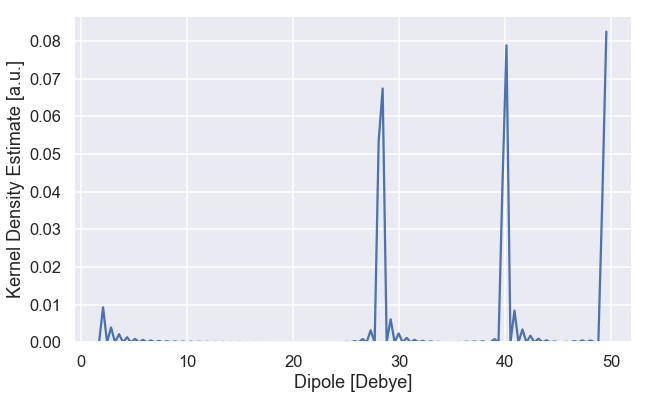

In [55]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
sns.kdeplot(monomer_4_df.total_dipole,bw=0.05,)
ax.set(xlabel='Dipole [Debye]',ylabel='Kernel Density Estimate [a.u.]')
ax.legend().remove()

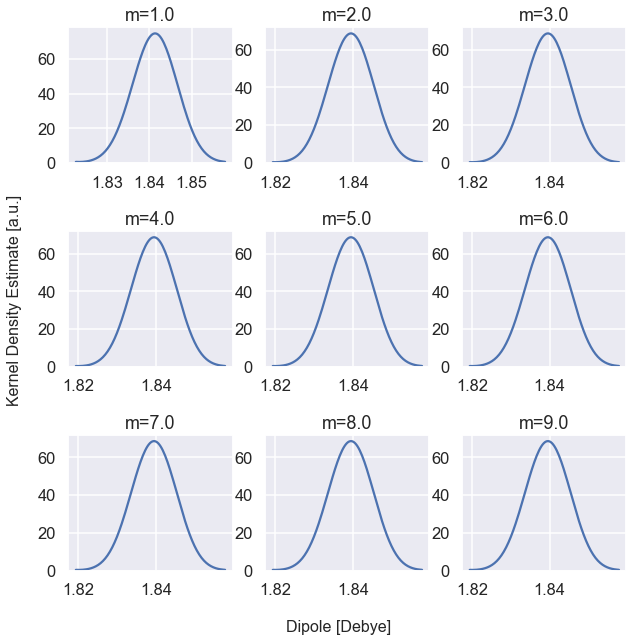

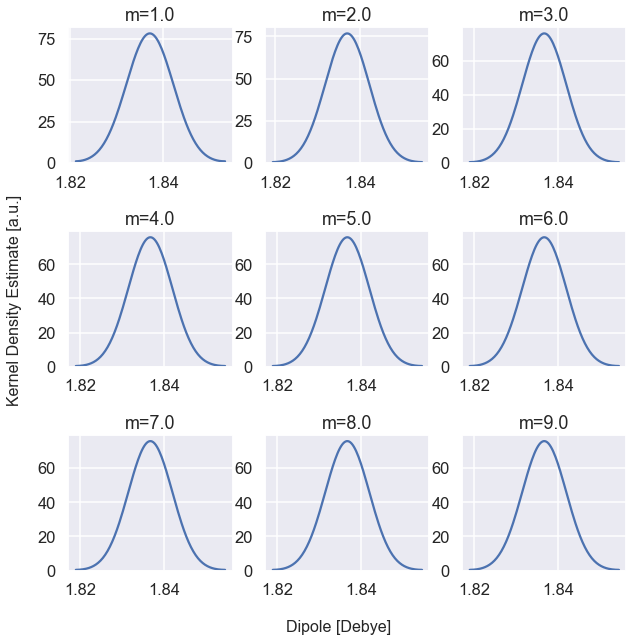

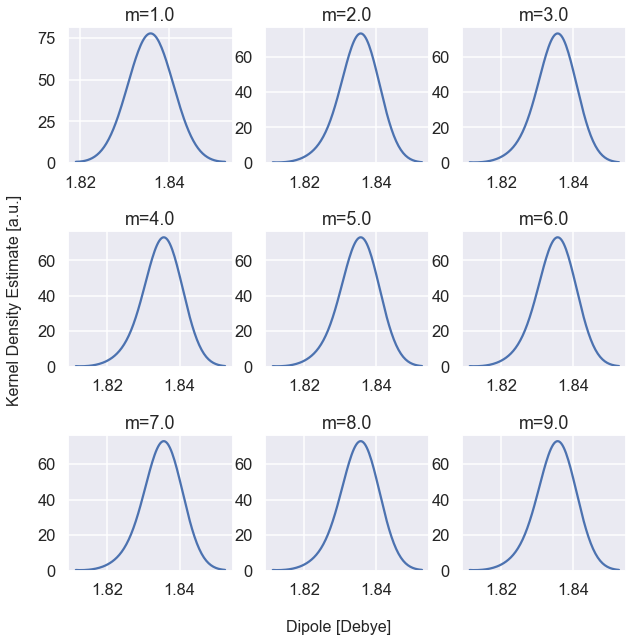

In [23]:
do_m_scan(monomer_4_df)
do_m_scan(monomer_5_df)
do_m_scan(monomer_6_df)

## Dimer

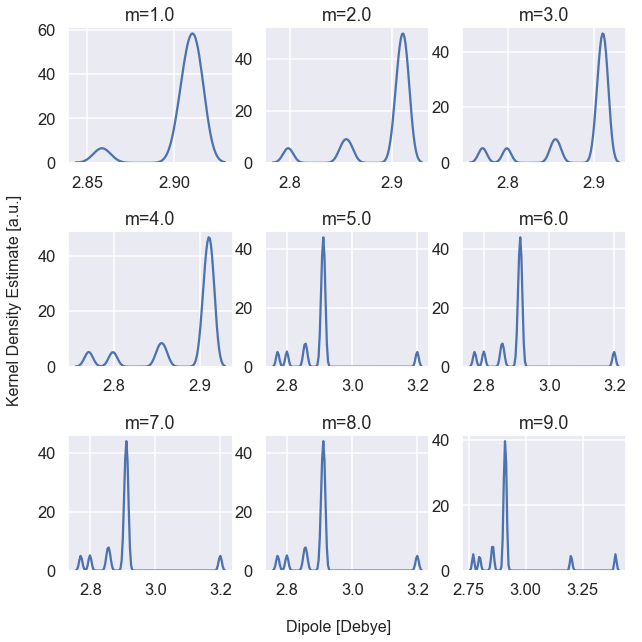

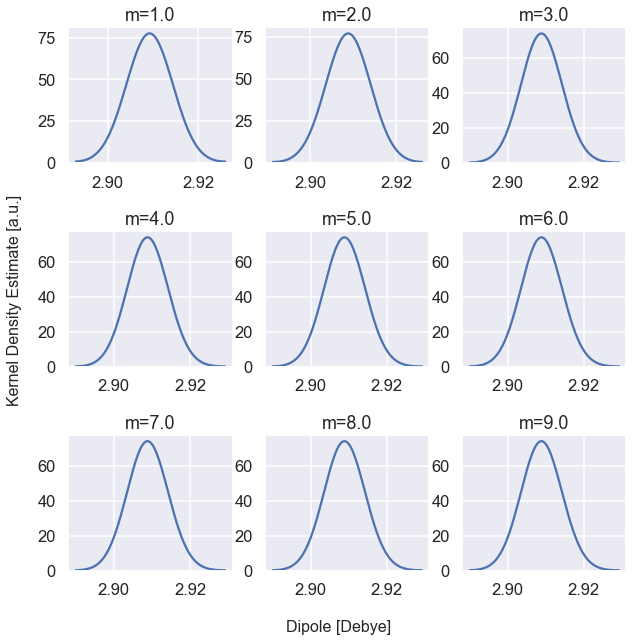

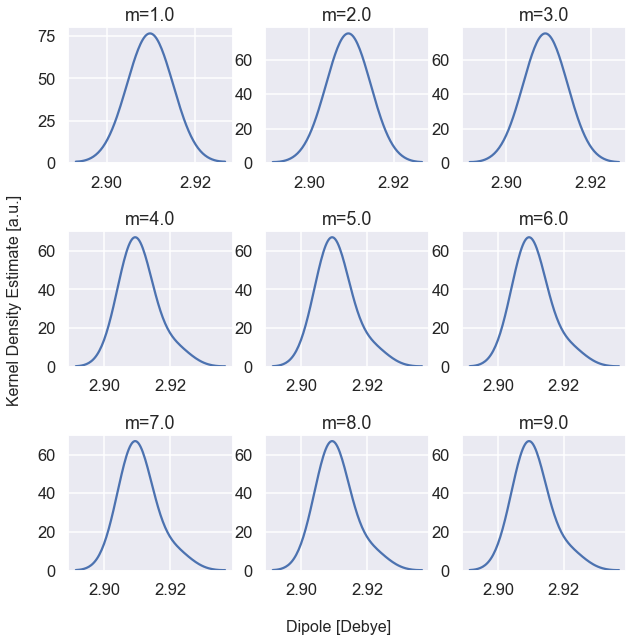

In [24]:
do_m_scan(dimer_4_df)
do_m_scan(dimer_5_df)
do_m_scan(dimer_6_df)

## Trimer

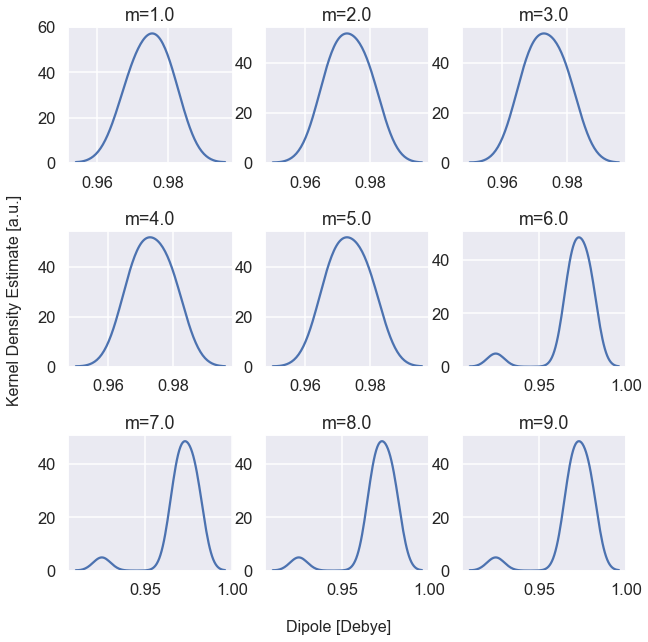

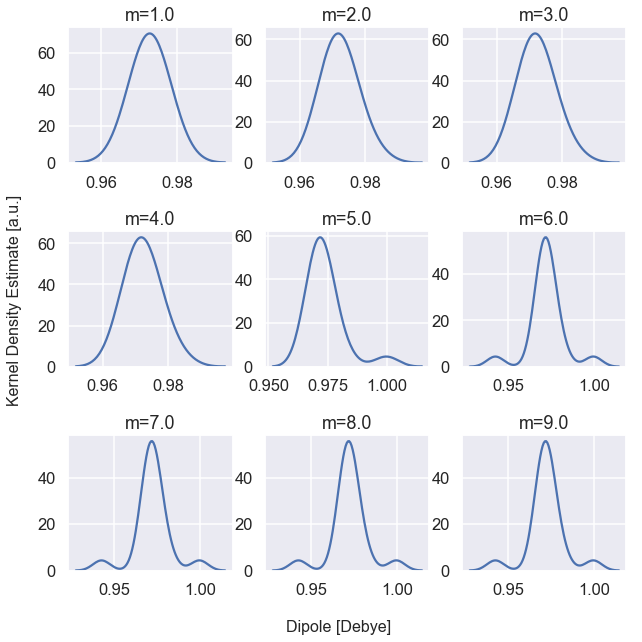

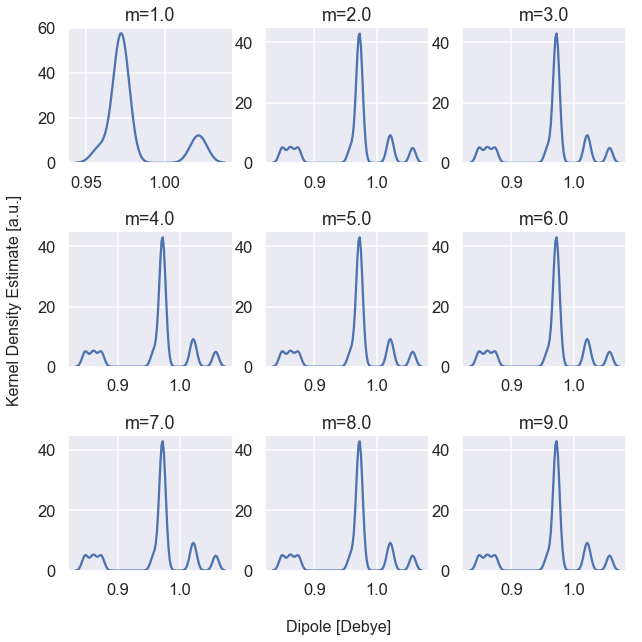

In [25]:
do_m_scan(trimer_4_df)
do_m_scan(trimer_5_df)
do_m_scan(trimer_6_df)

## Results

From the above plots, the following values are used moving forward:

- $m=1.0$
- $n_\text{kpts} = 4$ 
    - for MP grid ($n_\text{kpts}$ x $n_\text{kpts}$ x $n_\text{kpts}$)

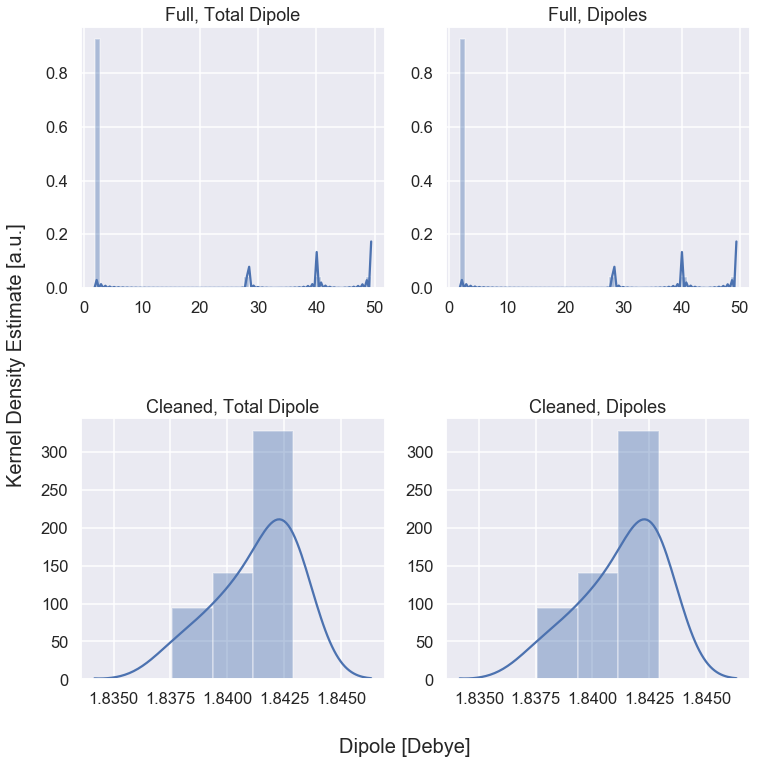

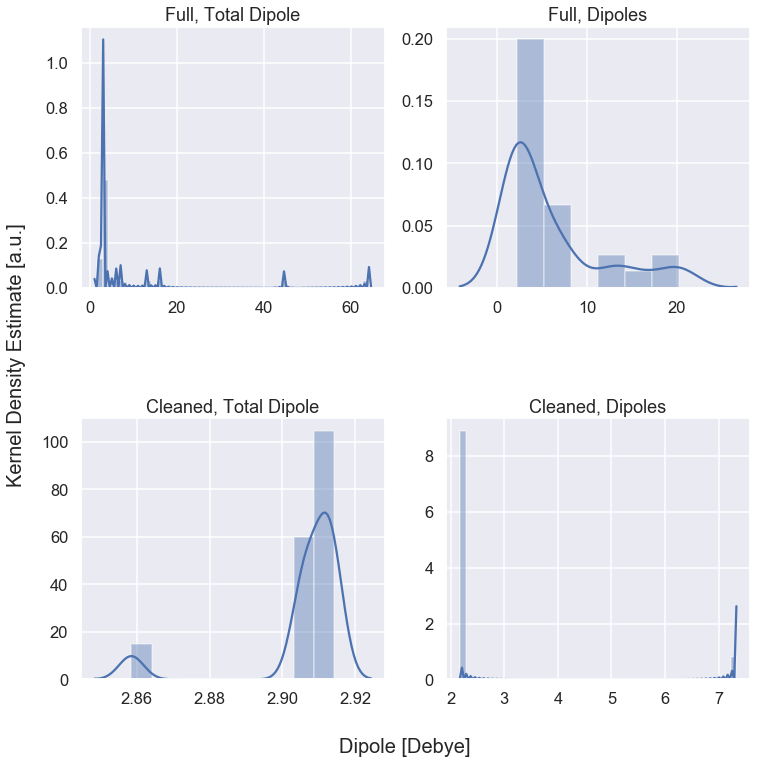

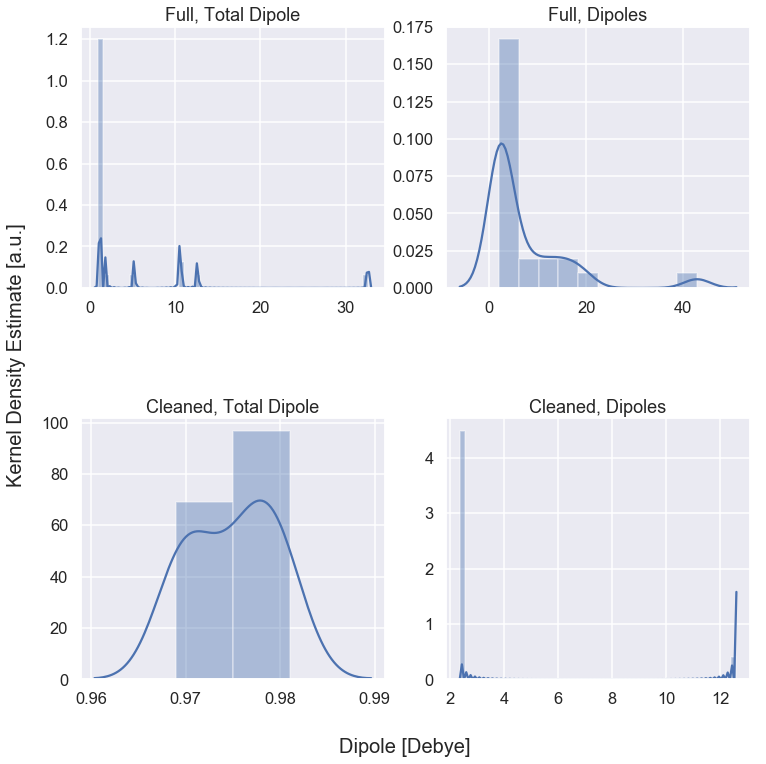

In [36]:
plot_before_after(monomer_4_df)
plot_before_after(dimer_4_df)
plot_before_after(trimer_4_df)

# Get Averages and Compare to Literature Values

Now, we compare the results for $m=1.0$ and $n_\text{kpts}=4$ to literature values.


## Final Results

We now plot all of the results. The error bars are calculated using the standard deviation and are not visible within the resolution of the graph.

,nmer,total_dipole,total_dipole_error,avg_dipole,avg_dipole_error
0,1,1.841257,0.000511,1.841257,0.000489
1,2,2.905825,0.004413,2.608098,0.410460
2,3,0.974993,0.001286,3.235002,0.813860


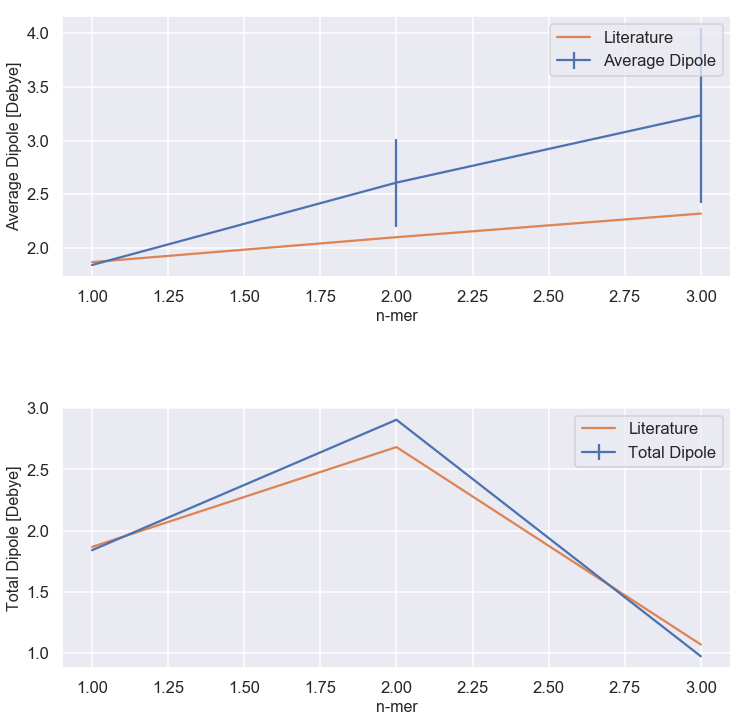

In [27]:
final_results_df, lit_values_df = make_final_graph(m=1.0)
final_results_df.head()